Training with hidden_size=64, learning_rate=0.001, short_w=5, mid_w=15, long_w=120
Training with hidden_size=64, learning_rate=0.001, short_w=5, mid_w=30, long_w=180
Training with hidden_size=64, learning_rate=0.001, short_w=10, mid_w=20, long_w=100
Training with hidden_size=64, learning_rate=0.0005, short_w=5, mid_w=15, long_w=120
Training with hidden_size=64, learning_rate=0.0005, short_w=5, mid_w=30, long_w=180
Training with hidden_size=64, learning_rate=0.0005, short_w=10, mid_w=20, long_w=100
Training with hidden_size=128, learning_rate=0.001, short_w=5, mid_w=15, long_w=120
Training with hidden_size=128, learning_rate=0.001, short_w=5, mid_w=30, long_w=180
Training with hidden_size=128, learning_rate=0.001, short_w=10, mid_w=20, long_w=100
Training with hidden_size=128, learning_rate=0.0005, short_w=5, mid_w=15, long_w=120
Training with hidden_size=128, learning_rate=0.0005, short_w=5, mid_w=30, long_w=180
Training with hidden_size=128, learning_rate=0.0005, short_w=10, mid_w=20,

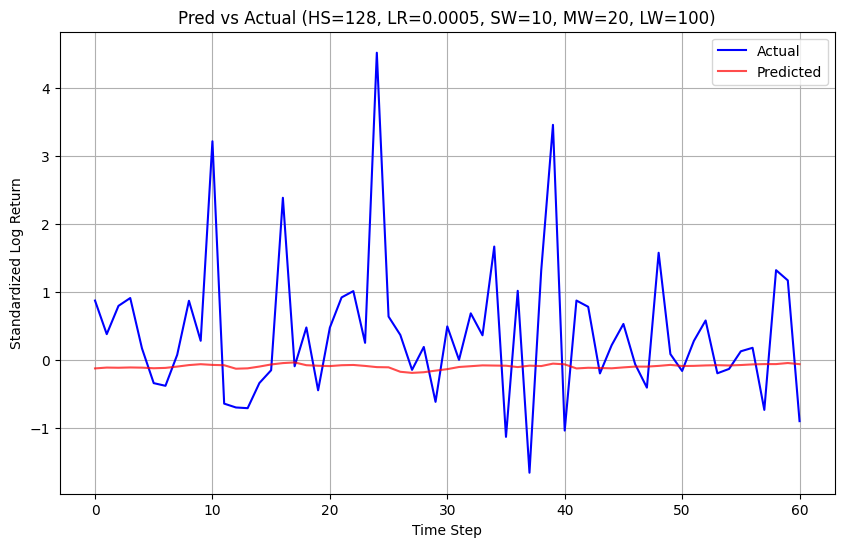

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def load_data(file_path, years=2):
    df = pd.read_csv(file_path)
    # Limit data to most recent 'years' years
    df = df.iloc[-years*252:]
    df = df[df['close'] > 0]
    log_returns = np.log(df['close']).diff().dropna()
    # standardize
    log_returns = (log_returns - log_returns.mean()) / log_returns.std()
    data_values = log_returns.values.astype(np.float32)
    return data_values, df

def create_sequences(data, short_w, mid_w, long_w):
    X_short, X_mid, X_long, Y = [], [], [], []
    max_w = long_w  # largest window
    for i in range(max_w, len(data)-1):
        s_start = i - short_w
        m_start = i - mid_w
        l_start = i - long_w
        
        short_seq = data[s_start:i].reshape(-1, 1)
        mid_seq = data[m_start:i].reshape(-1, 1)
        long_seq = data[l_start:i].reshape(-1, 1)
        
        target = data[i+1]  # next day's return
        X_short.append(short_seq)
        X_mid.append(mid_seq)
        X_long.append(long_seq)
        Y.append([target])
    return np.array(X_short, dtype=np.float32), np.array(X_mid, dtype=np.float32), np.array(X_long, dtype=np.float32), np.array(Y, dtype=np.float32)

class MultiScaleStockDataset(Dataset):
    def __init__(self, short_X, mid_X, long_X, Y):
        self.short_X = short_X
        self.mid_X = mid_X
        self.long_X = long_X
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, idx):
        return (self.short_X[idx], self.mid_X[idx], self.long_X[idx], self.Y[idx])

class MultiScaleLSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=2):
        super(MultiScaleLSTM, self).__init__()
        self.short_lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.mid_lstm   = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.long_lstm  = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(3 * hidden_size, 1)

    def forward(self, short_x, mid_x, long_x):
        _, (short_h, _) = self.short_lstm(short_x)
        _, (mid_h, _)   = self.mid_lstm(mid_x)
        _, (long_h, _)  = self.long_lstm(long_x)

        short_feat = short_h[-1,:,:]
        mid_feat   = mid_h[-1,:,:]
        long_feat  = long_h[-1,:,:]

        combined = torch.cat([short_feat, mid_feat, long_feat], dim=1)
        output = self.fc(combined)
        return output

def train_and_evaluate(data_values, short_window, mid_window, long_window,
                       train_ratio, val_ratio, test_ratio, hidden_size, learning_rate, 
                       num_epochs=50, early_stop_patience=10, batch_size=32):
    X_short_arr, X_mid_arr, X_long_arr, Y_arr = create_sequences(data_values, short_window, mid_window, long_window)
    n = len(Y_arr)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    X_short_train = X_short_arr[:train_end]
    X_mid_train   = X_mid_arr[:train_end]
    X_long_train  = X_long_arr[:train_end]
    Y_train       = Y_arr[:train_end]

    X_short_val = X_short_arr[train_end:val_end]
    X_mid_val   = X_mid_arr[train_end:val_end]
    X_long_val  = X_long_arr[train_end:val_end]
    Y_val       = Y_arr[train_end:val_end]

    X_short_test = X_short_arr[val_end:]
    X_mid_test   = X_mid_arr[val_end:]
    X_long_test  = X_long_arr[val_end:]
    Y_test       = Y_arr[val_end:]

    train_dataset = MultiScaleStockDataset(X_short_train, X_mid_train, X_long_train, Y_train)
    val_dataset   = MultiScaleStockDataset(X_short_val,   X_mid_val,   X_long_val,   Y_val)
    test_dataset  = MultiScaleStockDataset(X_short_test,  X_mid_test,  X_long_test,  Y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiScaleLSTM(hidden_size=hidden_size).to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for short_x, mid_x, long_x, y in train_loader:
            short_x, mid_x, long_x, y = short_x.to(device), mid_x.to(device), long_x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(short_x, mid_x, long_x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for short_x, mid_x, long_x, y in val_loader:
                short_x, mid_x, long_x, y = short_x.to(device), mid_x.to(device), long_x.to(device), y.to(device)
                outputs = model(short_x, mid_x, long_x)
                loss = criterion(outputs, y)
                val_losses.append(loss.item())

        avg_val_loss = np.mean(val_losses)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop_patience:
                break

    # Evaluate on Test
    model.load_state_dict(best_model_state)
    model.eval()
    test_losses = []
    all_preds = []
    all_actuals = []
    with torch.no_grad():
        for short_x, mid_x, long_x, y in test_loader:
            short_x, mid_x, long_x, y = short_x.to(device), mid_x.to(device), long_x.to(device), y.to(device)
            outputs = model(short_x, mid_x, long_x)
            loss = criterion(outputs, y)
            test_losses.append(loss.item())
            all_preds.append(outputs.cpu().numpy())
            all_actuals.append(y.cpu().numpy())

    avg_test_loss = np.mean(test_losses)
    all_preds = np.concatenate(all_preds).squeeze()
    all_actuals = np.concatenate(all_actuals).squeeze()

    return best_val_loss, avg_test_loss, all_preds, all_actuals

# Define parameter grids
hidden_size_values = [64, 128]
learning_rate_values = [0.001, 0.0005]
window_configs = [
    (5, 15, 120),
    (5, 30, 180),
    (10, 20, 100)
]

test_ratio = 0.15
val_ratio = 0.15
train_ratio = 1 - test_ratio - val_ratio

stock = 'UAL'
data_file = f'cache/{stock}_max_1day_data.csv'

data_values, df = load_data(data_file, years=2)

results = []
best_config = None
best_val_loss = float('inf')
best_preds = None
best_actuals = None
best_test_loss = None

# Try all combinations
for hs in hidden_size_values:
    for lr in learning_rate_values:
        for (sw, mw, lw) in window_configs:
            print(f"Training with hidden_size={hs}, learning_rate={lr}, short_w={sw}, mid_w={mw}, long_w={lw}")
            val_loss, test_loss, preds, actuals = train_and_evaluate(
                data_values, sw, mw, lw,
                train_ratio, val_ratio, test_ratio,
                hidden_size=hs, learning_rate=lr,
                num_epochs=50, early_stop_patience=10, batch_size=32
            )
            results.append((hs, lr, sw, mw, lw, val_loss, test_loss))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config = (hs, lr, sw, mw, lw)
                best_preds = preds
                best_actuals = actuals
                best_test_loss = test_loss

# Print all results
print("All results: (hidden_size, learning_rate, short_w, mid_w, long_w, val_loss, test_loss)")
for r in results:
    print(r)
print(f"Best config: {best_config} with val_loss={best_val_loss} and test_loss={best_test_loss}")

# Plot predictions vs actual for best model
plt.figure(figsize=(10,6))
plt.plot(best_actuals, label='Actual', color='blue')
plt.plot(best_preds, label='Predicted', color='red', alpha=0.7)
plt.title(f"Pred vs Actual (HS={best_config[0]}, LR={best_config[1]}, SW={best_config[2]}, MW={best_config[3]}, LW={best_config[4]})")
plt.xlabel("Time Step")
plt.ylabel("Standardized Log Return")
plt.legend()
plt.grid(True)
plt.show()